<a href="https://colab.research.google.com/github/GerardNaharro/Videojuego68k/blob/main/Practica2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
from PIL import Image

import numpy as np

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
#!ls "/content/drive/My Drive"
#!cd "/content/drive/My Drive/HorseHuman/Entreno/"

!ls "drive/MyDrive/HorseHuman/Entreno"
!cd "drive/MyDrive/HorseHuman/Entreno"
!unzip "drive/MyDrive/HorseHuman/Entreno/horse-or-human.zip"

horse-or-human.zip
Archive:  drive/MyDrive/HorseHuman/Entreno/horse-or-human.zip
  inflating: horses/horse01-0.png    
  inflating: horses/horse01-1.png    
  inflating: horses/horse01-2.png    
  inflating: horses/horse01-3.png    
  inflating: horses/horse01-4.png    
  inflating: horses/horse01-5.png    
  inflating: horses/horse01-6.png    
  inflating: horses/horse01-7.png    
  inflating: horses/horse01-8.png    
  inflating: horses/horse01-9.png    
  inflating: horses/horse02-0.png    
  inflating: horses/horse02-1.png    
  inflating: horses/horse02-2.png    
  inflating: horses/horse02-3.png    
  inflating: horses/horse02-4.png    
  inflating: horses/horse02-5.png    
  inflating: horses/horse02-6.png    
  inflating: horses/horse02-7.png    
  inflating: horses/horse02-8.png    
  inflating: horses/horse02-9.png    
  inflating: horses/horse03-0.png    
  inflating: horses/horse03-1.png    
  inflating: horses/horse03-2.png    
  inflating: horses/horse03-3.png    
  infla

In [4]:
horses_files = os.listdir('horses/')
horses_files = list(filter(lambda x: x != 'horses', horses_files))
horses_files = list(map(lambda p: f"horses/{p}", horses_files))

print("total horses images", len(horses_files))



humans_files = os.listdir('humans/')
humans_files = list(filter(lambda x: x != 'humans', humans_files))
humans_files = list(map(lambda p: f"humans/{p}", humans_files))

print("total humans images", len(humans_files))

img_files = horses_files + humans_files
print("total images", len(img_files))
random.shuffle(img_files)
#TODO: Aquí podeu substituir les X per nombres, d'aquesta manera podeu fer conjunts més grans o més petits.
# per entrenar més ràpid o més consistent
ttrain = img_files[:750] 
ttest = img_files[750:1027]

print("train size:", len(ttrain))
print("test size:", len(ttest))

total horses images 500
total humans images 527
total images 1027
train size: 750
test size: 277


(3, 227, 227)


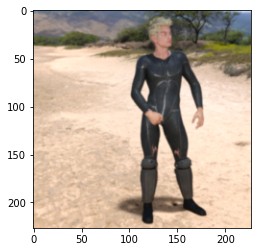

In [5]:
# image normalization
transform = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor()
])

# Constructor del dataset.
class HorseHumanDataset(Dataset):
    def __init__(self, image_paths, transform):
      super().__init__()
      self.paths = image_paths
      self.len = len(self.paths)
      self.transform = transform

    def __len__(self): 
      return self.len

    def __getitem__(self, index):
      path = self.paths[index]
      image = Image.open(path).convert('RGB')
      image = self.transform(image)
      label = 0 if 'humans' in path else 1
      return (image, label)


# creació dels conjunts d'entrenament i test
train_ds = HorseHumanDataset(ttrain, transform)
test_ds = HorseHumanDataset(ttest, transform)


train_dl = DataLoader(train_ds, batch_size=50)
test_dl = DataLoader(test_ds, batch_size=50)



batch = next(iter(train_ds))


# mostrar una imatge del batch
img = np.array(batch[0])
print(img.shape)
img = np.moveaxis(img, 0, -1)
plt.imshow(img)
plt.show()

TRANSFER LEARNING

In [6]:
alex = models.alexnet(weights=True)

print("-"*50)
print("Arquitectura AlexNet")
print("-"*50)
print(alex)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

--------------------------------------------------
Arquitectura AlexNet
--------------------------------------------------
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classi

In [7]:
for param in alex.features.parameters():
  param.requires_grad = False

my_net =  nn.Sequential(alex.features ,
                        nn.Flatten(1,-1),
                        alex.classifier
                        )

ENTRENAMENT


In [8]:
def train(model, device, train_loader, optimizer, epoch, log_interval=10, verbose=True):
    
    model.train()

    loss_v = 0

    for batch_idx, (data, target) in enumerate(train_loader):
    
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target, reduction='mean') 
        loss.backward()
        optimizer.step()
        if verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), loss.item()/ len(data)))
        loss_v += loss.item()

    loss_v /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(loss_v))
 
    return loss_v


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='mean') 
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max probability
            correct += pred.eq(target.view_as(pred)).sum().item()
 
  
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss

In [9]:
use_cuda = False
torch.manual_seed(33)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

epochs = 3
lr = 0.001

model = my_net.to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Parameters ", pytorch_total_params)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Guardam el valor de pèrdua mig de cada iteració (època)
train_l = np.zeros((epochs))
test_l = np.zeros((epochs))

# Bucle d'entrenament
for epoch in range(0, epochs):
    train_l[epoch] = train(model, device, train_dl, optimizer, epoch)
    test_l[epoch]  = test(model, device, test_dl)

Parameters  58631144
Train Epoch: 0 [0/750 (0%)]	Loss: 10.705090, Average: 0.214102
Train Epoch: 0 [50/750 (7%)]	Loss: 0.426379, Average: 0.008528
Train Epoch: 0 [100/750 (13%)]	Loss: 17.960443, Average: 0.359209
Train Epoch: 0 [150/750 (20%)]	Loss: 0.054665, Average: 0.001093
Train Epoch: 0 [200/750 (27%)]	Loss: 7.715976, Average: 0.154320
Train Epoch: 0 [250/750 (33%)]	Loss: 0.130378, Average: 0.002608
Train Epoch: 0 [300/750 (40%)]	Loss: 2.538520, Average: 0.050770
Train Epoch: 0 [350/750 (47%)]	Loss: 0.485423, Average: 0.009708
Train Epoch: 0 [400/750 (53%)]	Loss: 0.025977, Average: 0.000520
Train Epoch: 0 [450/750 (60%)]	Loss: 0.348606, Average: 0.006972
Train Epoch: 0 [500/750 (67%)]	Loss: 0.363998, Average: 0.007280
Train Epoch: 0 [550/750 (73%)]	Loss: 0.048061, Average: 0.000961
Train Epoch: 0 [600/750 (80%)]	Loss: 0.212037, Average: 0.004241
Train Epoch: 0 [650/750 (87%)]	Loss: 0.084408, Average: 0.001688
Train Epoch: 0 [700/750 (93%)]	Loss: 0.229013, Average: 0.004580

Train 

In [ ]:
#!rm -m horses/

In [10]:
!unzip "drive/MyDrive/HorseHuman/Test/validation-horse-or-human.zip"

Archive:  drive/MyDrive/HorseHuman/Test/validation-horse-or-human.zip
   creating: validation-horse-or-human/
   creating: validation-horse-or-human/VALhorses/
  inflating: validation-horse-or-human/VALhorses/horse1-000.png  
  inflating: validation-horse-or-human/VALhorses/horse1-105.png  
  inflating: validation-horse-or-human/VALhorses/horse1-122.png  
  inflating: validation-horse-or-human/VALhorses/horse1-127.png  
  inflating: validation-horse-or-human/VALhorses/horse1-170.png  
  inflating: validation-horse-or-human/VALhorses/horse1-204.png  
  inflating: validation-horse-or-human/VALhorses/horse1-224.png  
  inflating: validation-horse-or-human/VALhorses/horse1-241.png  
  inflating: validation-horse-or-human/VALhorses/horse1-264.png  
  inflating: validation-horse-or-human/VALhorses/horse1-276.png  
  inflating: validation-horse-or-human/VALhorses/horse1-298.png  
  inflating: validation-horse-or-human/VALhorses/horse1-335.png  
  inflating: validation-horse-or-human/VALhorses

In [17]:

horses_val_files = os.listdir('validation-horse-or-human/VALhorses/')
horses_val_files = list(filter(lambda x: x != 'VALhorses', horses_val_files))
horses_val_files = list(map(lambda p: f"validation-horse-or-human/VALhorses/{p}", horses_val_files))

print("total validation horses images", len(horses_val_files))



humans_val_files = os.listdir('validation-horse-or-human/VALhumans/')
humans_val_files = list(filter(lambda x: x != 'VALhumans', humans_val_files))
humans_val_files = list(map(lambda p: f"validation-horse-or-human/VALhumans/{p}", humans_val_files))

print("total validation humans images", len(humans_val_files))

img_val_files = horses_val_files + humans_val_files
print("total images", len(img_val_files))
random.shuffle(img_val_files)


total validation horses images 128
total validation humans images 128
total images 256


(3, 227, 227)


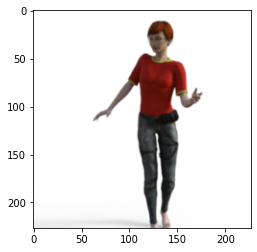


Test set: Average loss: 0.0357, Accuracy: 231/256 (90%)



tensor(0.0357)

In [19]:
val_ds = HorseHumanDataset(img_val_files, transform)
val_dl = DataLoader(val_ds, batch_size=50)

# mostrar una imatge del batch
batch = next(iter(val_ds))
img = np.array(batch[0])
print(img.shape)
img = np.moveaxis(img, 0, -1)
plt.imshow(img)
plt.show()


validacion = test(model, device, val_dl)
validacion